In [167]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [142]:
def load_complexity_scores():
    rsivl = "/ptmp/tshen/shared/RSIVL/labels.xls"
    visc = "/ptmp/tshen/shared/VISC/VISC-C/labels.csv"
    sav_obj = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_objects.xlsx"
    sav_sce = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_scenes.xlsx"
    sav_art = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_art.xlsx"
    sav_int = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_interior_design.xlsx"
    sav_sup = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_sup.xlsx"

    labels = {}
    labels['rsivl'] = pd.read_excel(rsivl)
    labels['rsivl'].rename(columns={'subjective scores': 'complexity', 'Unnamed: 0': 'filename'}, inplace=True)
    labels['rsivl']['filename'] = labels['rsivl']['filename'] + ".bmp"
    labels['visc'] = pd.read_csv(visc)
    labels['visc'].rename(columns={'score': 'complexity', 'image': 'filename'}, inplace=True)

    for v, n in zip([sav_obj, sav_sce, sav_art, sav_int, sav_sup], ["sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup"]):
        labels[n] = pd.read_excel(v)
        labels[n].rename(columns={'gt': 'complexity'}, inplace=True)
        labels[n]['filename'] = ["{}.jpg".format(i) for i in range(len(labels[n]))]

    for k in labels.keys():
        assert labels[k][['filename', 'complexity']].isnull().values.any() == False

    return labels

In [193]:
def load_predictions(folder="../out/2023July20", filenames=['4points', '8points', '16points', '32points', '64points']):
    rsivl = "{}/RSIVL".format(folder)
    visc = "{}/VISC".format(folder)
    sav_obj = "{}/Savoias-Objects".format(folder)
    sav_sce = "{}/Savoias-Scenes".format(folder)
    sav_art = "{}/Savoias-Art".format(folder)
    sav_int = "{}/Savoias-IntDesign".format(folder)
    sav_sup = "{}/Savoias-Suprematism".format(folder)

    preds = {}
    
    for v, n in zip([rsivl, visc, sav_obj, sav_sce, sav_art, sav_int, sav_sup], ["rsivl", "visc", "sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup"]):
        preds_dataset = []
        single_file_len = 0

        for f in filenames:
            df = pd.read_csv("{}/{}.csv".format(v, f), names=["filename", f], header=None)
            preds_dataset.append(df)
            single_file_len = len(df)

        combined_df = pd.concat([df.set_index("filename") for df in preds_dataset], axis=1, join='inner').reset_index()  # join on filename
        assert len(combined_df) == single_file_len
        assert combined_df.isnull().values.any() == False

        preds[n] = combined_df

    preds['rsivl']['filename'] = preds['rsivl']['filename'].str.replace('.json', '.bmp', regex=False)
    for k in ["visc", "sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup"]:
        preds[k]['filename'] = preds[k]['filename'].str.replace('.json', '.jpg', regex=False)

    return preds

In [145]:
def join_preds_labels(preds, labels):
    data = {}
    
    for k in ["rsivl", "visc", "sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup"]:
        data[k] = pd.concat([preds[k].set_index("filename"), labels[k][['filename', 'complexity']].set_index("filename")], axis=1, join='inner').reset_index()
        assert len(data[k]) == len(preds[k]) == len(labels[k])
        assert data[k].isnull().values.any() == False

    return data

In [152]:
levels = ['4points', '8points', '16points', '32points', '64points']

In [157]:
preds = load_predictions(folder="../out/2023July20", filenames=levels)
labels = load_complexity_scores()
data = join_preds_labels(preds, labels)

In [194]:
levels2 = ['64points0.88pred_iou_thresh', '64points0.92pred_iou_thresh', '64points0.95pred_iou_thresh', '64points0.97pred_iou_thresh', '64points0.99pred_iou_thresh']
preds2 = load_predictions(folder="../out/2023July21", filenames=levels2)
data2 = join_preds_labels(preds2, labels)

# Correlations

In [198]:
def get_correlations(data, levels):
    correlations = {}

    for dataset in data.keys():
        correlations[dataset] = {}
        columns = ['complexity'] + levels

        for i in range(len(columns)):
            correlations[dataset][columns[i]] = {}
            for j in range(i+1, len(columns)):
                correlations[dataset][columns[i]][columns[j]] = stats.pearsonr(data[dataset][columns[i]], data[dataset][columns[j]])

    return correlations

In [199]:
correlations = get_correlations(data, levels)
correlations2 = get_correlations(data2, levels2)

In [211]:
def plot_column_against_others(c1, c2=None):
    if c2 is None:
        c2 = c1

    plt.figure(figsize=(12, 4.5))
    plt.subplot(1, 2, 1)
    for dataset in correlations.keys():
        plt.plot(correlations[dataset][c1].keys(), [x.statistic for x in correlations[dataset][c1].values()], label=dataset)

    plt.xlabel("Granularity")
    plt.ylabel("Pearson Correlation")
    plt.legend()

    plt.subplot(1, 2, 2)
    for dataset in correlations2.keys():
        plt.plot(correlations2[dataset][c2].keys(), [x.statistic for x in correlations2[dataset][c2].values()], label=dataset)

    plt.xlabel("Granularity")
    plt.ylabel("Pearson Correlation")
    plt.legend()

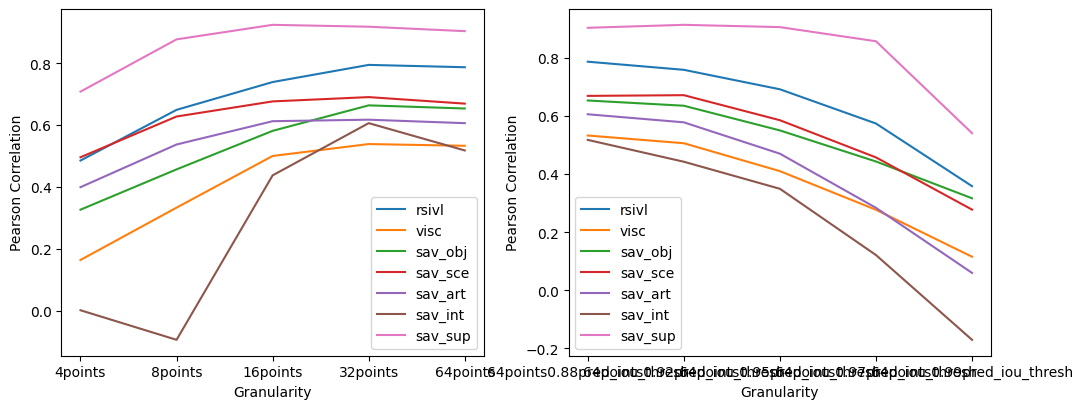

In [212]:
plot_column_against_others("complexity")

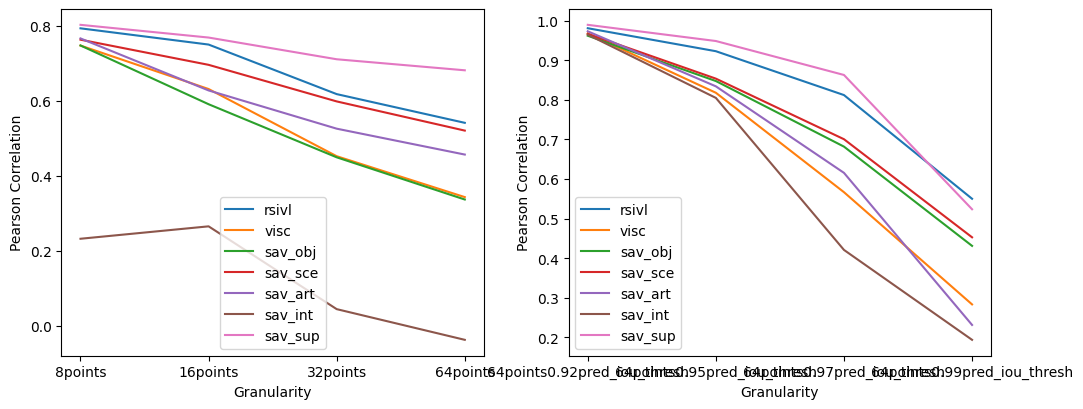

In [213]:
plot_column_against_others("4points", "64points0.88pred_iou_thresh")

# Scatters